## PFDA Project - Contact Center Performance Analysis
by David O'Sullivan

## 1. Introduction

This notebook contains my analysis of PWCs contact centre data. The goal of the notebook is to analyse KPI's, spot trends and find ways to improve performance overall. The text in this notebook will be kept to a minimum as requested however some sections are more complex than others and require detailed explanations.

All visuals associated with this notebook can be found in the Project Visuals folder. References are all above the code they are associated with.

In [202]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading from MySQL

The code below is used to connect to a database I created in MySQL. As this is a public notebook I created a config file containing any sensitive information. I was unable to find a config file so created one within my terminal via bash scripts.

The next step was using mysql.connector.connect to establish a connection to the MySQL database. This was the most straightforawd step as we did this during the semester. As I only needed to run one straightforward query there was no need to create a cursor. Instead I defined the query and ran it with the connection to load it into the pandas dataframe (df = pd.read_sql(query, connection))

When originally running the code everything looked okay except for the time column. This was coming up as "0 days" followed by the time. I decided the best way to handle this was to use lambda to convert the column to a string and then slice it to only show the time section of the rows [7:15], excluding "0 Days". I'd be unable to analyse the data properly with time as a string so dt.time is used in the data preperation section to rectify this.

Refs:

Create INI config file : https://www.quora.com/How-do-you-create-an-INI-config-file

Connecting MySQL Using Connector : https://dev.mysql.com/doc/connector-python/en/connector-python-example-connecting.html

pd.read_sql : https://blog.panoply.io/how-to-read-a-sql-query-into-a-pandas-dataframe

lambda to change data type : https://stackoverflow.com/questions/51341532/want-to-use-a-lambda-function-to-change-the-type-of-a-cell-if-it-is-type-float



In [203]:
import mysql.connector
from configparser import ConfigParser

# Define the path to config file
config_path = '/Users/davidosullivan/Documents/my_project/config_files/config.ini'

# Read the config.ini file
config = ConfigParser()
config.read(config_path)

# Retrieve the database connection details
host = config.get('mysql', 'host')
user = config.get('mysql', 'user')
password = config.get('mysql', 'password')
database = config.get('mysql', 'database')

# Connect to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Query to retrieve all data
query = "SELECT * FROM call_data"

# Load the data into a pandas DataFrame
df = pd.read_sql(query, connection)

# Close the connection to the database
connection.close()

# Convert the 'time' column to a string in the format HH:MM:SS (Removing the unneccessary sting data 0:7)
df['time'] = df['time'].apply(lambda x: str(x)[7:15])

df.head()


/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_86041/1896661745.py:29: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



,call_id,agent,date,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
0,ID0001,Diane,2021-01-01,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
1,ID0002,Becky,2021-01-01,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2,ID0003,Stewart,2021-01-01,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
3,ID0004,Greg,2021-01-01,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
4,ID0005,Becky,2021-01-01,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


## 2. Data Preperation

In [204]:
# Set Index
df.set_index('date', inplace=True)
df.head()

,call_id,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating
date,,,,,,,,,
2021-01-01,ID0001,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0
2021-01-01,ID0002,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0
2021-01-01,ID0003,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0
2021-01-01,ID0004,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0
2021-01-01,ID0005,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0


#### Additional column converting average talk duration from minutes to seconds is needed for future analysis.

Refs:

https://stackoverflow.com/questions/5522031/convert-timedelta-to-total-seconds

https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.total_seconds.html

In [205]:
# Ensure 'AvgTalkDuration' is in string format
df['avg_talk_duration'] = df['avg_talk_duration'].astype(str)

# Convert 'AvgTalkDuration' to seconds
df['avg_talk_duration_seconds'] = pd.to_timedelta(df['avg_talk_duration']).dt.total_seconds()


In [206]:
# Check are there null values to deal with
df.isnull().sum()

call_id                         0
agent                           0
time                            0
topic                           0
answered                        0
resolved                        0
speed_of_answer_in_seconds      0
avg_talk_duration               0
satisfaction_rating             1
avg_talk_duration_seconds     946
dtype: int64

In [207]:
# Check for duplicates
duplicates = df.duplicated().sum()
duplicates

0

In [208]:
# Drop Irrelevant Columns
df = df.drop(columns=['call_id'])
df.head()

,agent,time,topic,answered,resolved,speed_of_answer_in_seconds,avg_talk_duration,satisfaction_rating,avg_talk_duration_seconds
date,,,,,,,,,
2021-01-01,Diane,09:12:58,Contract related,Y,Y,109.0,0:02:23,3.0,143.0
2021-01-01,Becky,09:12:58,Technical Support,Y,N,70.0,0:04:02,3.0,242.0
2021-01-01,Stewart,09:47:31,Contract related,Y,Y,10.0,0:02:11,3.0,131.0
2021-01-01,Greg,09:47:31,Contract related,Y,Y,53.0,0:00:37,2.0,37.0
2021-01-01,Becky,10:00:29,Payment related,Y,Y,95.0,0:01:00,3.0,60.0


#### An additional column putting time of day into categories is needed for future analysis. This is done by combining pandas datetime function with IF, ELIF and ELSE statements.

Refs:

https://stackoverflow.com/questions/32375471/pandas-convert-strings-to-time-without-date


https://stackoverflow.com/questions/32113707/how-would-i-put-an-if-statement-inside-a-function

In [209]:
# Ensure in datetime format
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

# Define a function to categorize the time
def categorise_time(time):
    if time >= pd.to_datetime('09:00:00').time() and time < pd.to_datetime('12:00:00').time():
        return 'Morning'
    elif time >= pd.to_datetime('12:00:00').time() and time < pd.to_datetime('15:00:00').time():
        return 'Afternoon'
    elif time >= pd.to_datetime('15:00:00').time() and time < pd.to_datetime('18:00:00').time():
        return 'Evening'
    else:
        return 'Night'

# Apply the function to create a new column
df['time_of_day_category'] = df['time'].apply(categorise_time)


In [210]:
df['avg_talk_duration_seconds'].describe()

count    4054.000000
mean      224.922792
std       111.381555
min        30.000000
25%       130.000000
50%       226.000000
75%       319.000000
max       420.000000
Name: avg_talk_duration_seconds, dtype: float64

## Section 2 - EDA

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 2021-01-01 to 2021-03-31
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   agent                       5000 non-null   object 
 1   time                        5000 non-null   object 
 2   topic                       5000 non-null   object 
 3   answered                    5000 non-null   object 
 4   resolved                    5000 non-null   object 
 5   speed_of_answer_in_seconds  5000 non-null   float64
 6   avg_talk_duration           5000 non-null   object 
 7   satisfaction_rating         4999 non-null   float64
 8   avg_talk_duration_seconds   4054 non-null   float64
 9   time_of_day_category        5000 non-null   object 
dtypes: float64(3), object(7)
memory usage: 429.7+ KB


In [212]:
df.describe()

,speed_of_answer_in_seconds,satisfaction_rating,avg_talk_duration_seconds
count,5000.00000,4999.000000,4054.000000
mean,54.74580,2.760152,224.922792
std,40.18013,1.722751,111.381555
min,0.00000,0.000000,30.000000
25%,19.00000,1.000000,130.000000
50%,53.00000,3.000000,226.000000
75%,90.00000,4.000000,319.000000
max,125.00000,5.000000,420.000000


#### Visualize data to help find insights

Boxplot Ref : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

<Figure size 1000x600 with 0 Axes>

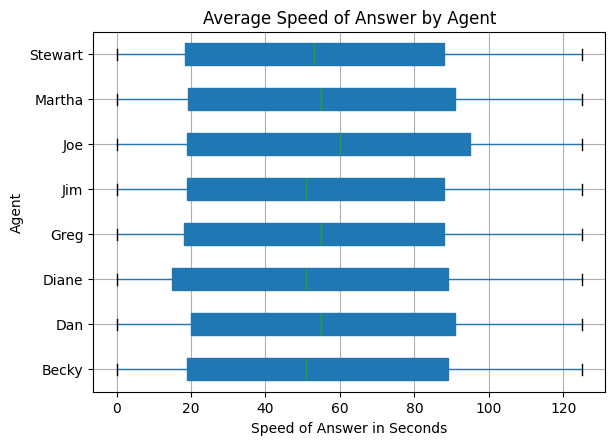

In [264]:
plt.figure(figsize=(10, 6))
df.boxplot(column='speed_of_answer_in_seconds', by='agent', vert=False, patch_artist=True)
plt.title('Average Speed of Answer by Agent')
plt.suptitle('')
plt.xlabel('Speed of Answer in Seconds')
plt.ylabel('Agent')

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Average_Speed_of_Answer_by_Agent.png")

plt.show()


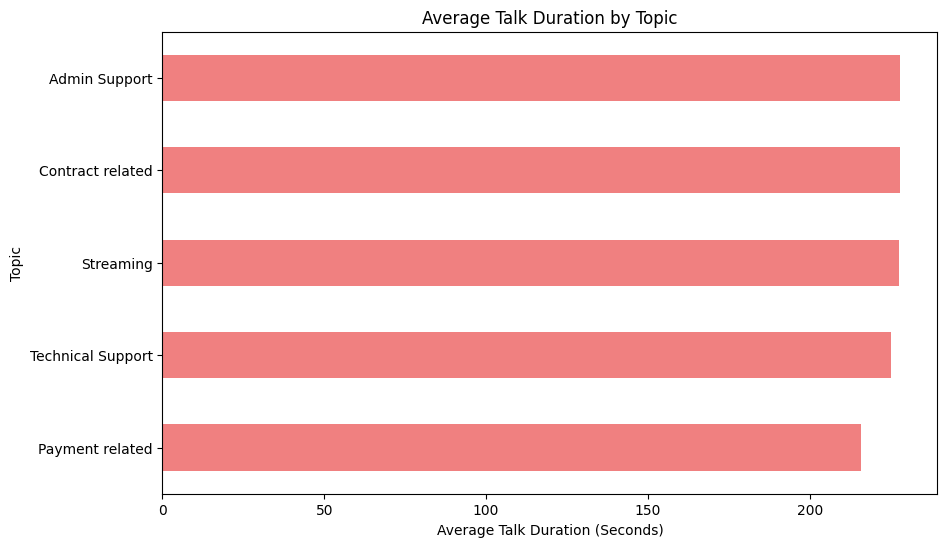

In [255]:
plt.figure(figsize=(10, 6))
df.groupby('topic')['avg_talk_duration_seconds'].mean().sort_values().plot(kind='barh', color='lightcoral')
plt.title('Average Talk Duration by Topic')
plt.xlabel('Average Talk Duration (Seconds)')
plt.ylabel('Topic')


plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Average_Talk_Duartion_by_Topic.png")

plt.show()


Pie Chart Refs: 

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html

https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct

/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_86041/4223744005.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



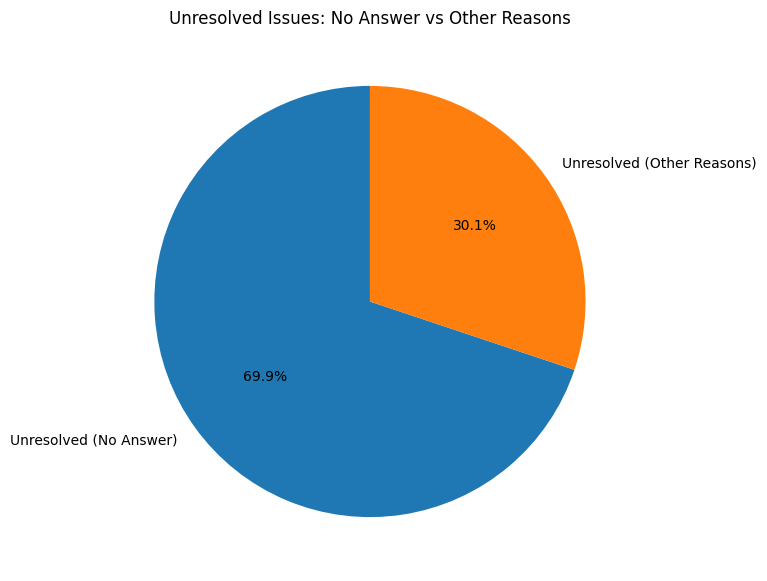

In [256]:
# Filter for unresolved calls (resolved == 'N')
unresolved_calls = df[df['resolved'] == 'N']

# Create a column to track unresolved issues due to calls not being answered
unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'

# Count unresolved calls due to no answer vs other reasons
unresolved_counts = unresolved_calls['unresolved_due_to_no_answer'].value_counts()

# Map True/False to labels
labels = ['Unresolved (No Answer)', 'Unresolved (Other Reasons)']

# Ensure the order matches labels
values = [unresolved_counts[True], unresolved_counts[False]]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Unresolved Issues: No Answer vs Other Reasons')

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Unresolved_Issues_Pie_Chart.png")

plt.show()

Plot Refs:

https://stackoverflow.com/questions/46992158/unable-to-resample-then-plot-a-pandas-data-frame

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

https://www.geeksforgeeks.org/matplotlib-axes-axes-axhline-in-python/

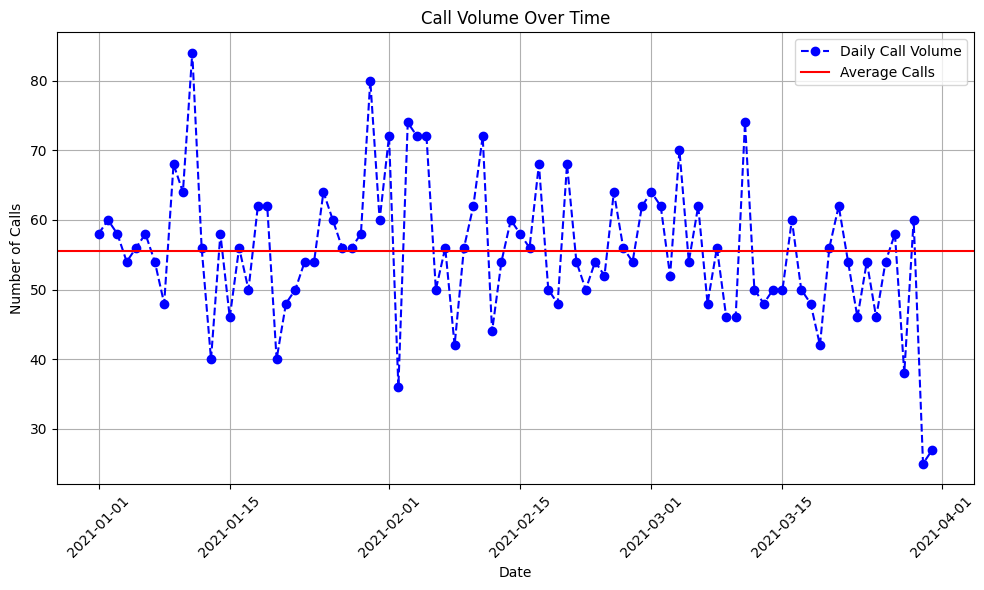

In [257]:
df.index = pd.to_datetime(df.index)

# Resample the data by day ('D') & use .size() to count the values
call_volume_daily = df.resample('d').size()

# Calculate the average call volume
average_calls = call_volume_daily.mean()

# Plot the call volume over time (daily)
plt.figure(figsize=(10, 6))
plt.plot(call_volume_daily.index, call_volume_daily.values, marker='o', linestyle='--', color='b', label='Daily Call Volume')
plt.axhline(y=average_calls, color='r', linestyle='-', label='Average Calls')
plt.title('Call Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Call_Volume_Line_Plot.png")

plt.show()

## KPI Analysis 

## 1) Operational Efficiency 

#### (i) Average Call Duration

In [217]:
avg_call_duration = df['avg_talk_duration_seconds'].mean().round()
avg_call_duration

225.0

In [218]:
agent_avg_duration = df.groupby('agent')['avg_talk_duration_seconds'].mean().round()

agent_avg_duration


agent
Becky      220.0
Dan        231.0
Diane      219.0
Greg       227.0
Jim        228.0
Joe        224.0
Martha     224.0
Stewart    226.0
Name: avg_talk_duration_seconds, dtype: float64

In [219]:
topic_avg_duration = df.groupby('topic')['avg_talk_duration_seconds'].mean().round()

topic_avg_duration

topic
Admin Support        228.0
Contract related     228.0
Payment related      216.0
Streaming            228.0
Technical Support    225.0
Name: avg_talk_duration_seconds, dtype: float64

#### Look at combinations of agents and topics where call duartion is above average

In [220]:
# Group by agent and topic & calculate the mean handling time
agent_topic_avg = df.groupby(['agent', 'topic'])['avg_talk_duration_seconds'].mean().reset_index()

# Filter combinations where the average handling time is greater than 260 seconds
high_handling_time = agent_topic_avg[agent_topic_avg['avg_talk_duration_seconds'] > 225]

high_handling_time = high_handling_time.sort_values('avg_talk_duration_seconds', ascending=False)
# Display the results
print("Combinations of Agent and Topic with Average Handling Time > 225 seconds:\n", high_handling_time)

Combinations of Agent and Topic with Average Handling Time > 225 seconds:
       agent              topic  avg_talk_duration_seconds
18     Greg          Streaming                 247.864865
16     Greg   Contract related                 246.888889
7       Dan    Payment related                 240.933962
35  Stewart      Admin Support                 240.648936
23      Jim          Streaming                 237.607843
21      Jim   Contract related                 236.157025
19     Greg  Technical Support                 234.911111
25      Joe      Admin Support                 231.913978
38  Stewart          Streaming                 231.542169
20      Jim      Admin Support                 231.000000
5       Dan      Admin Support                 230.528736
34   Martha  Technical Support                 230.156863
28      Joe          Streaming                 229.933333
11    Diane   Contract related                 229.684783
9       Dan  Technical Support                 228.8086

#### Review Agents and Topics that are most frequently above the 95th percentile

In [221]:
outliers = df[df['avg_talk_duration_seconds'] > df['avg_talk_duration_seconds'].quantile(0.95)]

# Frequency analysis for agents
agent_outlier_counts = outliers['agent'].value_counts()

# Frequency analysis for topics
topic_outlier_counts = outliers['topic'].value_counts()

# Display results
print("Agents most frequently in outliers:")
print(agent_outlier_counts)

print("\nTopics most frequently in outliers:")
print(topic_outlier_counts)

Agents most frequently in outliers:
agent
Dan        34
Diane      26
Stewart    24
Becky      24
Greg       23
Martha     22
Joe        21
Jim        21
Name: count, dtype: int64

Topics most frequently in outliers:
topic
Contract related     44
Streaming            44
Payment related      42
Admin Support        34
Technical Support    31
Name: count, dtype: int64


#### Review the combinations of topics and agents that are most frequently above the 95th percentile

In [222]:
# Group by agent and topic, and count the occurrences
agent_topic_counts = outliers.groupby(['agent', 'topic']).size().reset_index(name='count')

# Sort by the count in descending order
agent_topic_counts_sorted = agent_topic_counts.sort_values(by='count', ascending=False)

agent_topic_counts_sorted.head(10)

,agent,topic,count
7,Dan,Payment related,11
21,Jim,Contract related,9
36,Stewart,Contract related,9
8,Dan,Streaming,8
2,Becky,Payment related,8
10,Diane,Admin Support,8
29,Joe,Technical Support,7
1,Becky,Contract related,6
9,Dan,Technical Support,6
28,Joe,Streaming,6


In [223]:
# Group by Agent and Topic & Calculate the average
grouped_avg_duration = df.groupby(['agent', 'topic'])['avg_talk_duration_seconds'].mean()

# Compare each groups average with overall average 
above_avg_handling_time = grouped_avg_duration[grouped_avg_duration > 240]

above_avg_handling_time


agent    topic           
Dan      Payment related     240.933962
Greg     Contract related    246.888889
         Streaming           247.864865
Stewart  Admin Support       240.648936
Name: avg_talk_duration_seconds, dtype: float64

## (ii) Resolution Rate

/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_86041/3061812743.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



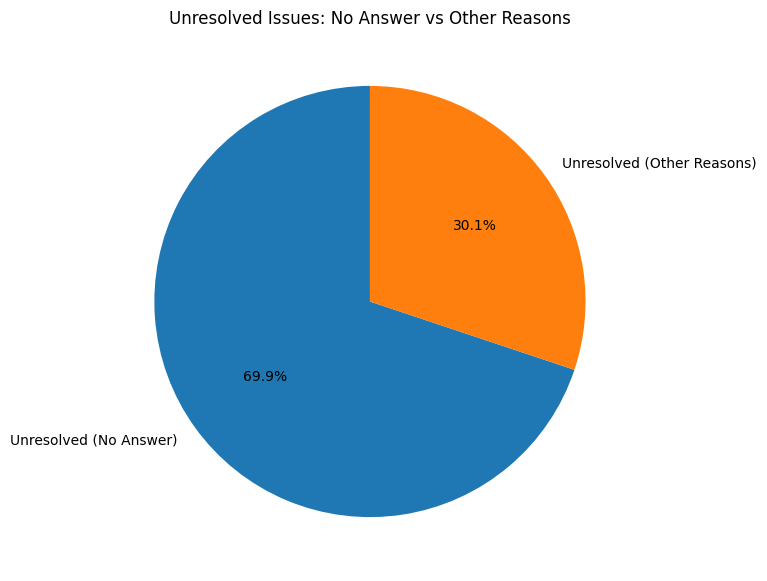

In [224]:
# Same Visual from EDA section for reference

# Filter for unresolved calls (resolved == 'N')
unresolved_calls = df[df['resolved'] == 'N']

# Create a column to track unresolved issues due to calls not being answered
unresolved_calls['unresolved_due_to_no_answer'] = unresolved_calls['answered'] == 'N'

# Count unresolved calls due to no answer vs other reasons
unresolved_counts = unresolved_calls['unresolved_due_to_no_answer'].value_counts()

# Map True/False to labels
labels = ['Unresolved (No Answer)', 'Unresolved (Other Reasons)']

# Ensure the order matches labels
values = [unresolved_counts[True], unresolved_counts[False]]

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(values, labels=labels, autopct='%.1f%%', startangle=90)
plt.title('Unresolved Issues: No Answer vs Other Reasons')
plt.show()


#### Count and visualize resolved vs unresolved

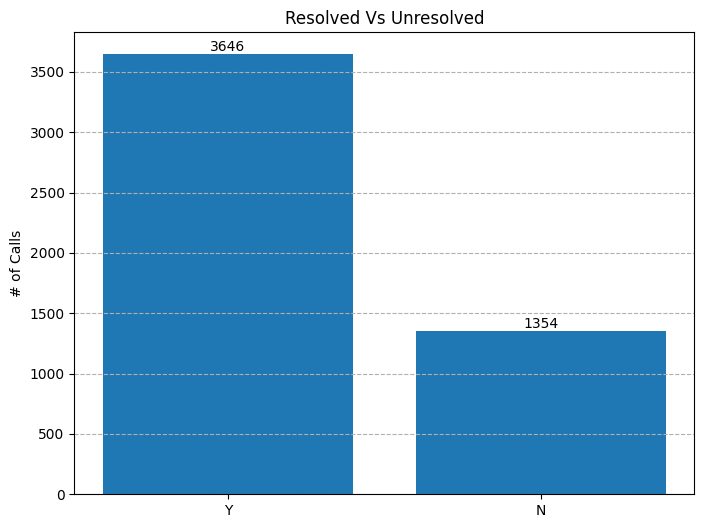

In [258]:
counts = df['resolved'].value_counts()

# Create a bar chart
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(counts.index, counts.values)

# Add count labels to the bars
ax.bar_label(bars, fmt='%g', fontsize=10)

# Formatting the plot
ax.set_title('Resolved Vs Unresolved')
ax.set_xlabel('')
ax.set_ylabel('# of Calls')
ax.grid(axis='y', linestyle='--')

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Resolved_Vs_Unresolved.png")

plt.show()

#### Calculate Resolution Rate

In [226]:
# Calculate total issues
total_issues = df['resolved'].count()

# Count resolved issues
resolved_issues = (df['resolved'] == 'Y').sum()

# Calculate the percentage
percentage_resolved = (resolved_issues / total_issues) * 100

(f"Percentage of resolved issues: {percentage_resolved:.0f}%")

'Percentage of resolved issues: 73%'

#### Calculate resolution rate by topic and agent

In [227]:
# Calculate resolution rates by topic
resolution_by_topic = df.groupby('topic')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Calculate resolution rates by agent
resolution_by_agent = df.groupby('agent')['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Display insights
print("Resolution Rate by Topic:\n", resolution_by_topic)
print("\nResolution Rate by Agent:\n", resolution_by_agent)


Resolution Rate by Topic:
 topic
Admin Support        74.1
Contract related     72.6
Payment related      72.4
Streaming            73.3
Technical Support    72.2
Name: resolved, dtype: float64

Resolution Rate by Agent:
 agent
Becky      73.2
Dan        74.4
Diane      71.4
Greg       72.9
Jim        72.8
Joe        73.5
Martha     72.3
Stewart    72.9
Name: resolved, dtype: float64


#### Show combination of agents and topics where resolution rate is below average

In [228]:
# Group by Topic and Agent to get the average resolution rate
resolution_by_topic_agent = df.groupby(['topic','agent'])['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Filter to get resolution rates below the average (73%)
low_resolution_rate = resolution_by_topic_agent[resolution_by_topic_agent<73]

# Sort in Ascending order
low_resolution_rate = low_resolution_rate.sort_values(ascending=True)

print(f'Focus topics and agents for improvement\n',low_resolution_rate)



Focus topics and agents for improvement
 topic              agent  
Streaming          Martha     65.4
Technical Support  Greg       66.4
Contract related   Diane      66.7
Payment related    Stewart    67.2
                   Diane      68.0
Technical Support  Martha     68.1
Contract related   Becky      68.4
Payment related    Jim        70.4
Technical Support  Diane      70.5
Streaming          Jim        71.1
Technical Support  Jim        71.3
Payment related    Dan        71.5
                   Becky      71.7
Admin Support      Greg       72.3
                   Joe        72.5
Contract related   Joe        72.8
                   Greg       72.8
Admin Support      Martha     72.8
Name: resolved, dtype: float64


#### Total calls and unanswered calls correlation

In [229]:
# Group data by time of day to calculate total and unanswered calls
time_of_day_summary = df.groupby('time_of_day_category').agg(total_calls=('answered', 'count'),unanswered_calls=('answered', lambda x: (x == 'N').sum()))

# Compute correlation
correlation_time_of_day = time_of_day_summary['total_calls'].corr(time_of_day_summary['unanswered_calls']).round(5)

print("Correlation between total calls and unanswered calls by time of day:", correlation_time_of_day)


Correlation between total calls and unanswered calls by time of day: 0.9988


## 2) Customer Satisfaction - Satisfaction Rating

#### Average satisfaction rating across resolution, topic, agent and time of day

In [230]:
# Average Satisfaction Rating
avg_satisfaction_rating = df['satisfaction_rating'].mean().round(2)

# Satisfaction by resolution status
satisfaction_by_resolution = df.groupby('resolved')['satisfaction_rating'].mean().round(2)

# Satisfaction by topic
satisfaction_by_topic = df.groupby('topic')['satisfaction_rating'].mean().round(2)

# Satisfaction by Agent
satisfaction_by_agent = df.groupby('agent')['satisfaction_rating'].mean().round(2)

# Satisfaction by Time of Day
satisfaction_by_time = df.groupby('time_of_day_category')['satisfaction_rating'].mean().round(2)


In [231]:
print("Average Satisfaction Rating:\n", avg_satisfaction_rating)
print("Satisfaction if Resolved:\n", satisfaction_by_resolution)
print("\nSatisfaction by Topic:\n", satisfaction_by_topic)

Average Satisfaction Rating:
 2.76
Satisfaction if Resolved:
 resolved
N    1.03
Y    3.40
Name: satisfaction_rating, dtype: float64

Satisfaction by Topic:
 topic
Admin Support        2.79
Contract related     2.73
Payment related      2.76
Streaming            2.82
Technical Support    2.70
Name: satisfaction_rating, dtype: float64


In [232]:
print("\nSatisfaction by Agent:\n", satisfaction_by_agent)
print("Satisfaction By Time of Day:\n", satisfaction_by_time )


Satisfaction by Agent:
 agent
Becky      2.76
Dan        2.85
Diane      2.70
Greg       2.74
Jim        2.73
Joe        2.72
Martha     2.80
Stewart    2.79
Name: satisfaction_rating, dtype: float64
Satisfaction By Time of Day:
 time_of_day_category
Afternoon    2.70
Evening      2.77
Morning      2.81
Night        3.07
Name: satisfaction_rating, dtype: float64


#### Agent and Topic combinations where satisfaction rating is below average

In [233]:
satisfaction_by_topic_agent = df.groupby(['topic','agent'])['satisfaction_rating'].mean().round(2)

low_satisfaction_rating = satisfaction_by_topic_agent[satisfaction_by_topic_agent < 2.76]

low_satisfaction_rating


topic              agent  
Admin Support      Diane      2.69
                   Greg       2.71
                   Joe        2.71
Contract related   Becky      2.51
                   Dan        2.67
                   Diane      2.63
                   Greg       2.72
Payment related    Diane      2.72
                   Greg       2.74
                   Jim        2.67
                   Joe        2.63
                   Stewart    2.69
Streaming          Joe        2.70
                   Stewart    2.65
Technical Support  Becky      2.71
                   Diane      2.66
                   Greg       2.64
                   Jim        2.58
                   Martha     2.55
                   Stewart    2.70
Name: satisfaction_rating, dtype: float64

#### Visualize Satisfaction Rating Overtime 

Plot Refs:

https://stackoverflow.com/questions/46992158/unable-to-resample-then-plot-a-pandas-data-frame

https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

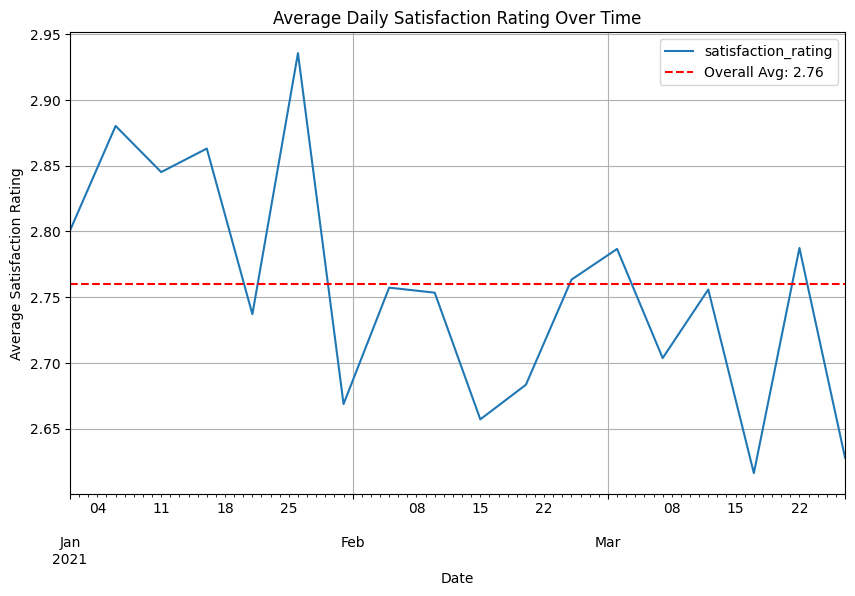

In [259]:
# Ensure the index is of datetime type
df.index = pd.to_datetime(df.index)

# Resample the data to calculate the daily mean 
daily_average = df['satisfaction_rating'].resample('5D').mean()

# Plotting and title
daily_average.plot(kind='line', figsize=(10, 6), title="Average Daily Satisfaction Rating Over Time")

# Calculate the overall average satisfaction rating
overall_average = df['satisfaction_rating'].mean()

# Adding labels
plt.xlabel("Date")
plt.ylabel("Average Satisfaction Rating")
plt.grid(True)

# Adding a horizontal line for the overall average
plt.axhline(y=overall_average, color='red', linestyle='--', label=f'Overall Avg: {overall_average:.2f}')

plt.legend()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Satisfaction_Line_Plot.png")

plt.show()

## 3) Agent Performance 


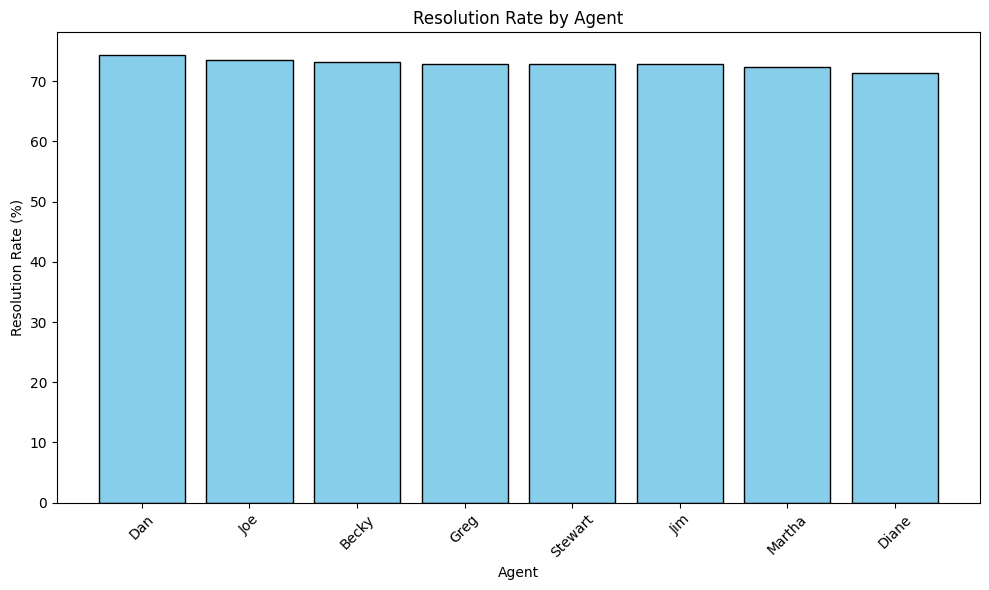

In [260]:
# Create a bar chart
resolution_by_agent_sorted = resolution_by_agent.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(resolution_by_agent_sorted.index, resolution_by_agent_sorted, color='skyblue', edgecolor='black')
plt.title('Resolution Rate by Agent')
plt.xlabel('Agent')
plt.ylabel('Resolution Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Resolution_Agent_Bar.png")

plt.show()

Refs:

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html?utm_source=chatgpt.com

https://datons.ai/unstack-dataframe-after-groupby-to-create-heat-matrix/


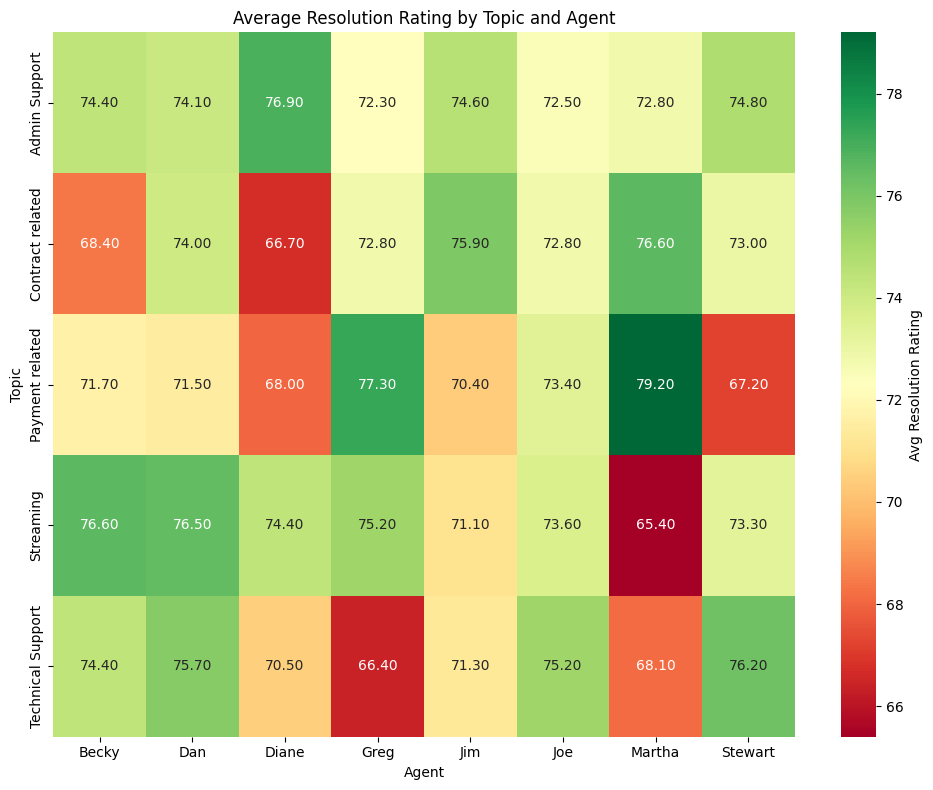

In [261]:
# Calculate the mean resolution rating by topic and agent
resolution_by_topic_agent = df.groupby(['topic','agent'])['resolved'].apply(lambda x: (x == 'Y').mean() * 100).round(1)

# Unstack the data for visualization (converting it to a 2D table)
resolution_matrix = resolution_by_topic_agent.unstack()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(resolution_matrix, annot=True, cmap='RdYlGn', fmt=".2f", cbar_kws={'label': 'Avg Resolution Rating'})
plt.title('Average Resolution Rating by Topic and Agent')
plt.ylabel('Topic')
plt.xlabel('Agent')
plt.tight_layout()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Resolution_Heatmap.png")

plt.show()

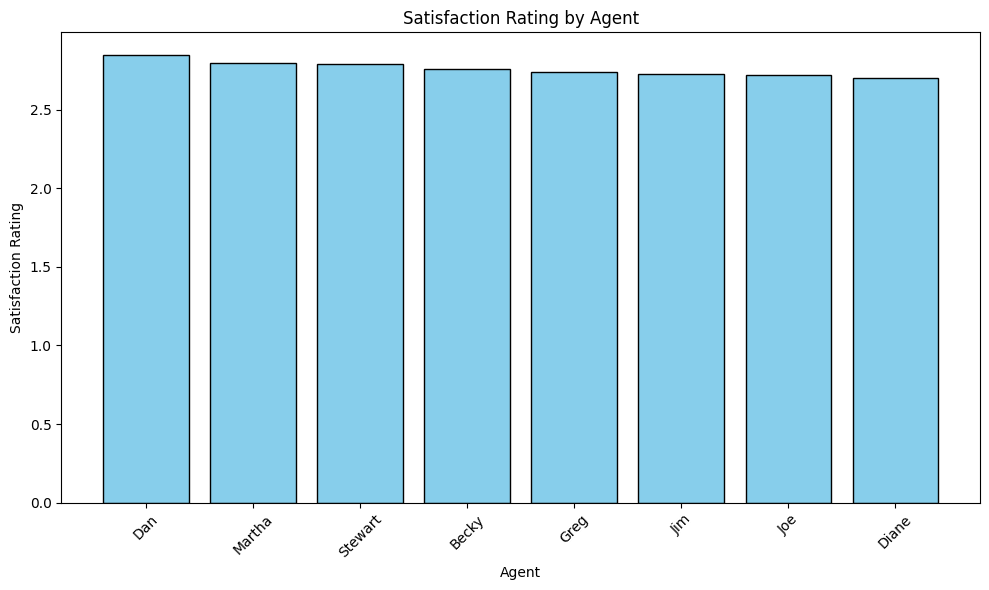

In [262]:
satisfaction_by_agent_sorted = satisfaction_by_agent.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(satisfaction_by_agent_sorted.index, satisfaction_by_agent_sorted, color='skyblue', edgecolor='black')
plt.title('Satisfaction Rating by Agent')
plt.xlabel('Agent')
plt.ylabel('Satisfaction Rating')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Satisfaction_Agent_Bar.png")

plt.show()

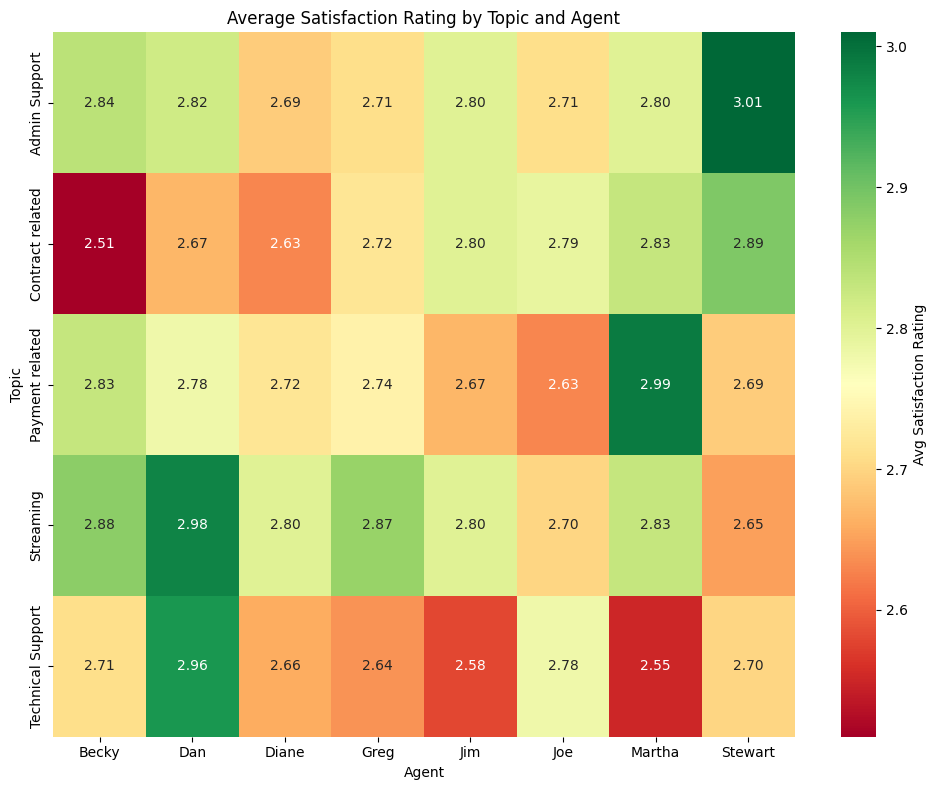

In [263]:
# Calculate the mean satisfaction rating by topic and agent
satisfaction_by_topic_agent = df.groupby(['topic', 'agent'])['satisfaction_rating'].mean().round(2)

# Unstack the data for visualization (converting it to a 2D table)
satisfaction_matrix = satisfaction_by_topic_agent.unstack()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(satisfaction_matrix, annot=True, cmap='RdYlGn', fmt=".2f", cbar_kws={'label': 'Avg Satisfaction Rating'})
plt.title('Average Satisfaction Rating by Topic and Agent')
plt.ylabel('Topic')
plt.xlabel('Agent')
plt.tight_layout()

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Satisfaction_Heatmap.png")

plt.show()

To get the correlation of the new variables I used pd.DataFrame. This creates a new DataFrame from the data specified. I provided the data as a dictionary. I then used .corr() to get the correlation between resolution_rate and satisfaction rating.

In [239]:
# To see if the correlation between resolution and satisfaction rating combine the dataset
combined_data = pd.DataFrame({
    'resolution_rate': resolution_by_topic_agent,
    'satisfaction_rating': satisfaction_by_topic_agent
}).dropna() 

# Calculate the correlation
correlation = combined_data.corr().loc['resolution_rate', 'satisfaction_rating']
print(f"Correlation between resolution rate and satisfaction rating: {correlation:.2f}")

Correlation between resolution rate and satisfaction rating: 0.54


Refs:

https://www.geeksforgeeks.org/python-seaborn-regplot-method/

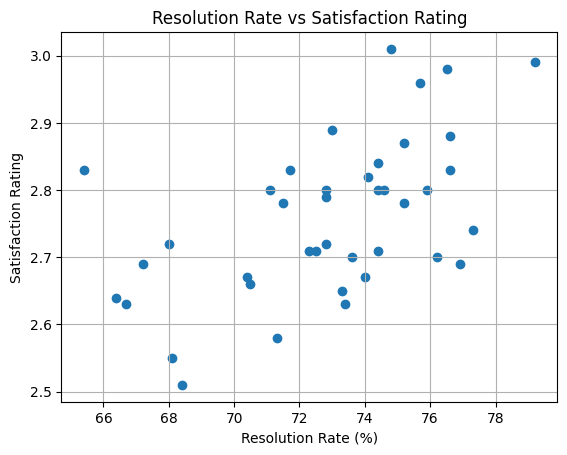

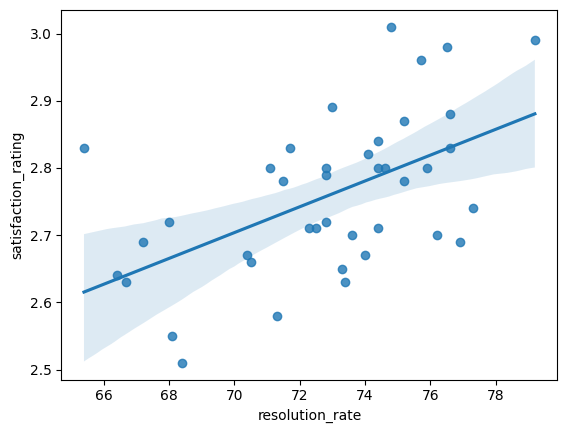

In [240]:
import matplotlib.pyplot as plt

plt.scatter(combined_data['resolution_rate'], combined_data['satisfaction_rating'])
plt.title('Resolution Rate vs Satisfaction Rating')
plt.xlabel('Resolution Rate (%)')
plt.ylabel('Satisfaction Rating')
plt.grid(True)
plt.show()

sns.regplot(
    x='resolution_rate',
    y='satisfaction_rating',
    data=combined_data,
)

plt.savefig("/Users/davidosullivan/Desktop/ATU_DataAnalytics_Semester2/Semester2_Repositories/PFDA/project/Project Visuals/Correlation.png")


## Advanced/Interactive Visuals w/ Plotly

Refs:

https://plotly.com/python/bar-charts/

https://stackoverflow.com/questions/70563166/stacked-barplot-in-plotly

In [241]:
import plotly.express as px

# Group data by agent and topic, and calculate the mean satisfaction rating
grouped_data = df.groupby(['agent', 'topic'])['satisfaction_rating'].mean().reset_index()

# Create a stacked bar chart
fig = px.bar(
    grouped_data,
    x='agent',
    y='satisfaction_rating',
    color='topic',
    title="Satisfaction Rating by Agent and Topic",
    labels={'satisfaction_rating': 'Avg Satisfaction Rating', 'topic': 'Topic'},
    barmode='stack'
)
fig.update_layout(xaxis_title="Agent", yaxis_title="Avg Satisfaction Rating")
fig.show()



Refs:

https://plotly.com/python/bar-charts/

In [242]:
# Filter for resolved issues
resolved_issues = df[df['resolved'] == 'Y']

# Count the number of resolved issues per agent
resolved_by_agent = resolved_issues.groupby('agent')['resolved'].count().reset_index()

# Sort agents by the number of resolved issues
resolved_by_agent = resolved_by_agent.sort_values(by='resolved', ascending=False)

# Create a bar chart
fig = px.bar(
    resolved_by_agent,
    x='agent',
    y='resolved',
    title="Top Performing Agents by Resolved Issues",
    labels={'agent': 'Agent', 'resolved': 'Number of Resolved Issues'},
    color='resolved',
    color_continuous_scale='Greens',
)

# Display
fig.show()


Refs:

https://plotly.com/python/funnel-charts/

In [243]:
# Create data for the funnel
funnel_data = pd.DataFrame({
    'Stage': ['Total Calls', 'Answered Calls', 'Resolved Calls'],
    'Count': [len(df), (df['answered'] == 'Y').sum(), (df['resolved'] == 'Y').sum()]
})

# Create the funnel chart
fig = px.funnel(funnel_data, x='Count', y='Stage', title="Call Flow Funnel")
fig.show()


Refs: 

https://plotly.com/python/animations/

In [244]:
# Group by date and agent to get the call volume
call_volume_data = df.groupby(['date', 'agent'])['agent'].size().reset_index(name='call_volume')

# Create the bar chart
fig = px.bar(
    call_volume_data,
    x='agent',
    y='call_volume',
    animation_frame='date',
    title="Agent Call Volume Over Time",
    labels={'agent': 'Agent', 'call_volume': 'Call Volume'},
    color='agent',
)

# Customize the layout
fig.update_layout(
    width=900,
    height=600,
)

# Display the animated bar chart
fig.show()


Ref:

https://www.geeksforgeeks.org/numpy-cumsum-in-python/

In [245]:
import plotly.express as px

# Group by date and agent to get the daily call volume
call_volume_data = df.groupby(['date', 'agent'])['agent'].size().reset_index(name='daily_call_volume')

# Calculate cumulative call volume for each agent
call_volume_data['cumulative_call_volume'] = call_volume_data.groupby('agent')['daily_call_volume'].cumsum()

# Create the animated bar chart for cumulative call volume
fig = px.bar(
    call_volume_data,
    x='agent',
    y='cumulative_call_volume',
    animation_frame='date',
    title="Agent Cumulative Call Volume Over Time",
    labels={'agent': 'Agent', 'cumulative_call_volume': 'Cumulative Call Volume'},
    color='agent',
)

# Customize the layout
fig.update_layout(
    width=900,
    height=600,
)

# Display the animated bar chart
fig.show()


#### Plotly Line Chart

For this interactive visual there was a bit more involved then the previous visuals so I'll be breaking down the code used. 

I first used .resample('D') which resamples the data into daily frequency, this is a method I've also used earlier in my notebook. Next, .count() is used to count the number or rowns for each day and I reset the index to turn the date index into a regular column.

In my daily_calls df I created two new columns calles "is_peak" and "is_trough" to highlight rows where the call volume exceeds the 75th percentile and is below the 25th percentile. This is done using .quantile() and the output in the rows is either true or false.

fig = go.Figure() uses Plotly's graph_objects to create a figure. 

.add_trace is used to add data plots to the figure. This is done three times in the code below. First to add the call volume line as well as highlighting the peaks and the troughs.

go.scatter is responsible for the type of visual we see. For example the first time it's used we have mode=line which creates the call volume line and the second time it's used mode=markers which is then defined in another line of code with a symbol.

When adding peaks and troughs setting x and y is slightly more difficult than doing so for the line chart. .loc is used to filter where is_peak/trough == True nas well as date / call_volume. marker=dict is used to set the color as green, font size as 8 and the symbol as a triangle. The markers reference below gives a list of all the different symbols that can be used.

The final part of the code is customizing the layout, setting the name of the title, xaxis, yaxis, etc. For 'template' there are several different themes you can choose from highlighted in another references below.

Refs:

.resample() - https://www.geeksforgeeks.org/python-pandas-dataframe-resample/

.quantile() - https://www.geeksforgeeks.org/pandas-dataframe-quantile/

line charts - https://plotly.com/python/line-charts/

trace/scatter/layout - https://plotly.com/python/creating-and-updating-figures/

markers - https://plotly.com/python/marker-style/

template/theme - https://plotly.com/python/templates/

In [246]:
import plotly.graph_objects as go

# Resample data by day to calculate daily call volumes
daily_calls = df.resample('D')['agent'].count().reset_index()
daily_calls.columns = ['date', 'call_volume']

# Identify peaks and troughs
daily_calls['is_peak'] = (daily_calls['call_volume'] > daily_calls['call_volume'].quantile(0.75))
daily_calls['is_trough'] = (daily_calls['call_volume'] < daily_calls['call_volume'].quantile(0.25))

# Create the line chart
fig = go.Figure()

# Add call volume line
fig.add_trace(go.Scatter(
    x=daily_calls['date'],
    y=daily_calls['call_volume'],
    mode='lines',
    name='Call Volume',
    line=dict(color='blue'),
))

# Highlight peaks
fig.add_trace(go.Scatter(
    x=daily_calls.loc[daily_calls['is_peak'], 'date'],
    y=daily_calls.loc[daily_calls['is_peak'], 'call_volume'],
    mode='markers',
    name='Peaks',
    marker=dict(color='green', size=8, symbol='triangle-up'),
))

# Highlight troughs
fig.add_trace(go.Scatter(
    x=daily_calls.loc[daily_calls['is_trough'], 'date'],
    y=daily_calls.loc[daily_calls['is_trough'], 'call_volume'],
    mode='markers',
    name='Troughs',
    marker=dict(color='red', size=8, symbol='triangle-down'),
))

# Customize the layout
fig.update_layout(
    title='Daily Call Volume Peaks and Troughs',
    xaxis_title='Date',
    yaxis_title='Call Volume',
    template='plotly_dark',
    width=900,
    height=600,
    showlegend=True,
)

# Display the chart
fig.show()


## Advanced Analysis

#### ANOVA Analysis Results Discussion :

The F-statistic (1.798) is not significant (p=0.126), indicating no substantial differences in average call durations across the topics. 

The model has an R squared of 0.002 which suggests the topics explain very little when it comes to call duration. 


All coefficients for topic categories are not significant except for payment related calls which are shorter.

Refs:

https://nicoleeic.github.io/Brain_and_Code/2019/09/02/ANOVA_new.html

https://www.statsmodels.org/stable/anova.html

https://www.youtube.com/watch?v=EWYzeZbchR0

https://www.statsmodels.org/dev/generated/statsmodels.stats.multicomp.pairwise_tukeyhsd.html

In [247]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Step 1: Prepare the data
df_clean = df.dropna(subset=['avg_talk_duration_seconds'])

# Step 2: Define the model
model = ols('avg_talk_duration_seconds ~ C(topic)', data=df_clean).fit()

# Step 3: Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the results
print("\nANOVA Table:")
print(anova_table)

# Step 4: Display full OLS regression summary
print("\nOLS Regression Results:")
print(model.summary())

# Step 5: Perform Tukey Post Hoc Test
print("\nTukey Post Hoc Test Results:")
tukey = pairwise_tukeyhsd(endog=df_clean['avg_talk_duration_seconds'], 
                          groups=df_clean['topic'], 
                          alpha=0.05)
print(tukey)




ANOVA Table:
                sum_sq      df         F    PR(>F)
C(topic)  8.914874e+04     4.0  1.797921  0.126326
Residual  5.019176e+07  4049.0       NaN       NaN

OLS Regression Results:
                                OLS Regression Results                               
Dep. Variable:     avg_talk_duration_seconds   R-squared:                       0.002
Model:                                   OLS   Adj. R-squared:                  0.001
Method:                        Least Squares   F-statistic:                     1.798
Date:                       Wed, 01 Jan 2025   Prob (F-statistic):              0.126
Time:                               17:54:34   Log-Likelihood:                -24855.
No. Observations:                       4054   AIC:                         4.972e+04
Df Residuals:                           4049   BIC:                         4.975e+04
Df Model:                                  4                                         
Covariance Type:                  

#### OLS Regression Analysis Results Discussion :

The R squared in these results is 0. This indicates that the variables used explain virtually none of the variation in satisfaction ratings.

The overall F-statistic is not significant further showing that these variables have little to no impact on satisfaction rating.

refs:

https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

https://www.geeksforgeeks.org/ordinary-least-squares-ols-using-statsmodels/

In [248]:
df_clean['resolved_Y'] = df_clean['resolved'].map({'Y': 1, 'N': 0})

import statsmodels.api as sm

# Define independent variables (X) and dependent variable (y)
X = df_clean[['speed_of_answer_in_seconds', 'avg_talk_duration_seconds', 'resolved_Y']]
y = df_clean['satisfaction_rating']

# Add a constant
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display results
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     satisfaction_rating   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                 -0.001
Method:                  Least Squares   F-statistic:                   0.06759
Date:                 Wed, 01 Jan 2025   Prob (F-statistic):              0.977
Time:                         17:54:34   Log-Likelihood:                -6532.0
No. Observations:                 4054   AIC:                         1.307e+04
Df Residuals:                     4050   BIC:                         1.310e+04
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

/var/folders/0d/mbrvmyx10n92tdtbjzgv0tjm0000gn/T/ipykernel_86041/2149759704.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Insights

#### Operational Efficiency:

Call Duration: While average call durations are consistent across agents and topics, a deeper analysis revealed that specific agent-topic combinations (e.g., Agent Dan and payment-related calls) contribute disproportionately to longer call durations. These could be targeted for training or process improvement.

Resolution Rate: Unanswered calls account for 70% of unresolved issues, as highlighted in the EDA. This is strongly correlated (0.9988) with call volume, indicating a need for better resource management during peak times.

#### Customer Satisfaction:
Unanswered calls are a major driver of poor satisfaction ratings, bringing down the average rating to 2.76. Resolved calls have a significantly higher average rating of 3.40.

Satisfaction ratings saw a steep decline in February and March, compared to January. This may indicate operational or seasonal challenges that need further exploration.

Agent Performance:
Performance across agents is fairly even, but specific agents and topics show weaknesses that can be addressed through training.
There is a moderate positive correlation (0.54) between resolution rates and satisfaction ratings, suggesting that resolving issues efficiently is a key driver of satisfaction.

#### Advanced Analysis:
Regression analysis showed that call duration and the speed of answering calls have minimal impact on satisfaction ratings. The main exception is payment-related calls, which are shorter and more efficient.
ANOVA analysis further supported that topics have little influence on call durations overall.

## Recommendation

1) Unanswered Calls - The biggest issue facing PWC is the volume of unanswered calls, this is impacting their KPIs; Satisfaction Rating and Resolution Rate. I'd recommend hiring additional agents to help handle the call volumes, especially during peak periods. 

2) Agent Training - Agents resolution rates at a high level are relatively positive but there are some combinations of topics and agents where there is room for improvement. I would recommend targeted training for these combinations. This should lead to overall improvements in resolution rates. Once the training is done paired t-Tests can be performed to see how beneficial the training was.

3) Data-Driven Decision Making - Use the heat maps and interactive visuals created to identify trends and performance gaps at a glance.

Adopting these recommendations will have a very positive impact on PWCs KPI's